In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'

# 'train': dataset.ImageFolder, 'val':dataset.ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transform=data_transforms[x])
                 for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images 

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # w, h, c
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)    

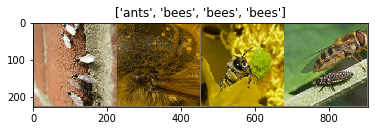

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model
- Scheduling the learning rate
- Saving the best model

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

###  Visualizing the model predictions

In [31]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return 
            model.train(mode=was_training)

### Finetuning the convnet 

In [26]:
model_ft = models.resnet18(pretrained=True) # original fc : (512, 1000)
num_ftrs = model_ft.fc.in_features # 512
model_ft.fc = nn.Linear(num_ftrs, 2) # new fc: (512, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate 

In [27]:
model_tf = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6703 Acc: 0.6721
val Loss: 0.4576 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.6050 Acc: 0.7541
val Loss: 0.1563 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5267 Acc: 0.7664
val Loss: 0.3044 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5003 Acc: 0.8033
val Loss: 0.2415 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4181 Acc: 0.8402
val Loss: 0.2349 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4604 Acc: 0.8115
val Loss: 0.4682 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.5633 Acc: 0.7623
val Loss: 0.2711 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3253 Acc: 0.8525
val Loss: 0.2023 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2852 Acc: 0.8689
val Loss: 0.1888 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3357 Acc: 0.8402
val Loss: 0.2014 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2912 Acc: 0.8566
val Loss: 0.2392 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2607 Acc: 0.8975
val Loss: 0.1733 Acc: 0.9412

Ep

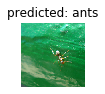

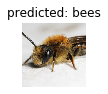

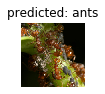

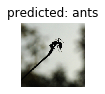

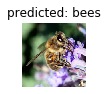

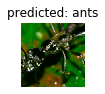

In [32]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor 
- Freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [37]:
model_conv = torchvision.models.resnet18(pretrained=True)

# freezing
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# oppsed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


### train and evaluate 

In [39]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6028 Acc: 0.6311
val Loss: 0.2081 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4060 Acc: 0.8115
val Loss: 0.2155 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5734 Acc: 0.7254
val Loss: 0.2192 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4397 Acc: 0.8156
val Loss: 0.1668 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4762 Acc: 0.7828
val Loss: 0.1972 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4335 Acc: 0.8197
val Loss: 0.2339 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4140 Acc: 0.7951
val Loss: 0.1606 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2910 Acc: 0.8852
val Loss: 0.1878 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3777 Acc: 0.8443
val Loss: 0.2172 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.4257 Acc: 0.8115
val Loss: 0.1777 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3469 Acc: 0.8648
val Loss: 0.1698 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3035 Acc: 0.8484
val Loss: 0.1667 Acc: 0.9477

Ep

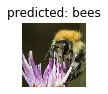

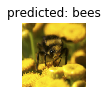

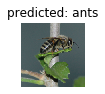

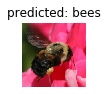

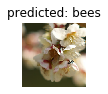

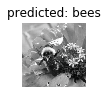

In [40]:
visualize_model(model_conv)

plt.ioff()
plt.show()